# Deep Learning - Lab Exercise 2

**WARNING:** you must have finished the first exercise before this one as you will re-use parts of the code.

In the first lab exercise, we built a simple linear classifier.
Although it can give reasonable results on the MNIST dataset (~92.5% of accuracy), deeper neural networks can achieve more the 99% accuracy on this dataset.
However, it can quickly become really impractical to explicitly code forward and backward passes.
Hence, it is useful to rely on an auto-diff library where we specify the forward pass only, and the backward pass is automatically deduced from the computational graph structure.

In this lab exercise, we will build a small and simple auto-diff lib that mimics the autograd mechanism from Pytorch (of course, we will simplify a lot!)
There is two goal:
- write the missing code
- understand the general structure of an auto-diff lib by looking closely at the code. It will help you to understand how Pytorch works!

In [1]:
# import libs that we will use
import os
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns

sns.set()

# To load the data we will use the script of Gaetan Marceau Caron
# You can download it from the course webiste and move it to the same directory that contains this ipynb file
import dataset_loader

%matplotlib inline

# Data

In [2]:
# Download mnist dataset 
if("mnist.pkl.gz" not in os.listdir(".")):
    !wget http://deeplearning.net/data/mnist/mnist.pkl.gz

# if you have it somewhere else, you can comment the lines above
# and overwrite the path below
mnist_path = "./mnist.pkl.gz"

In [3]:
# load the 3 splits
train_data, dev_data, test_data = dataset_loader.load_mnist(mnist_path)

label: 4


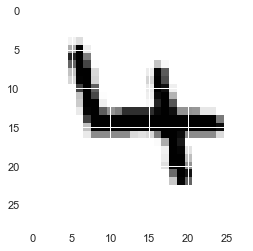

In [4]:
index = 900
label = train_data[1][index]
picture = train_data[0][index]

print("label: %i" % label)
plt.imshow(picture.reshape(28,28), cmap='Greys')

# Computation nodes

1.   List item
2.   List item



Instead of directly manipulating numpy arrays, we will manipulate abstraction that contains:
- a value (i.e. a numpy array)
- a bool indicating if we wish to compute the gradient with respect to the value
- the gradient with respect to the value
- the operation to call during backpropagation

There will be two kinds of nodes:
- Tensor: a generic computation node
- Parameter: a computation node that is used to store parameters of the network. Parameters are always leaf nodes, i.e. they cannot be build from other computation nodes.

Our implementation of the backward pass will be really simple and inefficient in the general case.
We will just apply the derivative function for a given tensor and then call the ones of its antecedents, recursively.
This simple algorithm is good enough for this exercise.
You may want to look at the implementation of the relu (given below) to understand what you have to do.

Note that a real implementation of backprop will store temporary values during forward that can be used during backward to improve computation speed. We do not do that here.

**Report bonus:** give an example of computation graph for which this simple backprop implementation will be inefficient.

In [5]:
class Tensor:
    def __init__(self, data, require_grad=False):
        # test type of data: should be np array
        if isinstance(data, float):
            data = np.array([data,])
        if type(data) != np.ndarray:
            raise RuntimeError("Input should be a numpy array")

        # store data for this tensor
        self.data = data
        self.require_grad = require_grad
        
        # this values should be set to enable autograd!
        self.gradient = None
        self.d = None
        self.backptr = None
        
    def zero_grad(self):
        """
        Set the gradient of thie tensor to 0
        """
        if self.require_grad:
            self.gradient = np.zeros_like(self.data)
            
    def accumulate_gradient(self, gradient):
        """
        Accumulate gradient for this tensor
        """
        if gradient.shape != self.data.shape:
            raise RuntimeError("Invalid gradient dimension")

        if self.gradient is None:
            self.gradient = np.copy(gradient)
        else:
            self.gradient += gradient
            
    def backward(self, g=None):
        """
        The backward pass!
        If g != None, then g is the gradient for the current node.
        i.e. g will be != None only for the loss output.
        
        You should call the function stored in self.d with correct arguments,
        and then recursively call the backward methods of tensors in the backptr list if:
        1. they require a gradient
        2. they are of type Tensor: check with isinstance(o, Tensor)
        """
        if not self.require_grad:  # stop right now if this node does not require a gradient
            return
        
        if g is not None:
            if isinstance(g, float):
                g = np.array([g])
            if type(g) != np.ndarray:
                raise RuntimeError("Gradient should be a numpy array")
            if g.shape != self.data.shape:
                raise RuntimeError("Gradient of different size than the value!")
                
            self.gradient = g

        if self.d is not None:
            self.d(self.backptr, self.gradient)
        if self.backptr is not None:
            for backprop in self.backptr:
                if backprop.require_grad and not isinstance(backprop, Parameter):
                    backprop.backward()

        #raise RuntimeError("TODO!")
    
    
class Parameter(Tensor):
    """
    This class will be used to store parameters of the network only!
    """
    def __init__(self, data, name="unamed"):
        super().__init__(data, require_grad=True)
        self.name = name
        
    def backward(self):
        raise RuntimeError("You cannot backprop from a Parameter node")

# Functions

Functions manipulate tensors and build the required information for autograd.
A function returns a Tensor that should have require_grad = True if at least of the arguments require a gradient.

In [6]:
def any_require_grad(l):
    """
    Input:
    - l: an iterable (e.g. a list)
    Ouput:
    - True if any tensor in the input requires a gradient
    """
    return any(t.require_grad for t in l)

In [7]:
# Here is an exemple with the ReLU
def relu(x):
    v = np.maximum(0, x.data)
    
    output = Tensor(v, require_grad=x.require_grad)
    output.d = backward_relu
    output.backptr = [x]
    
    return output

def backward_relu(backptr, g):
    x, = backptr
    
    # the gradient is accumulated in the arguments only if required
    if x.require_grad:
        x.accumulate_gradient(g * (x.data > 0))

In [8]:
def tanh(x):
    v = np.tanh(x.data)
    output = Tensor(v, require_grad=x.require_grad)
    output.d = backward_tanh
    output.backptr = [x]
    return output

def backward_tanh(backptr, g):
    x, = backptr
    
    if x.require_grad:
        x.accumulate_gradient(g * (x.data > 0))

Next, we implement the affine transform operation.
You can reuse the code from the first lab exercise, with one difference: you have to compute the gradient with respect to x too!

In [9]:
def affine_transform(W, b, x):
    v = np.dot(W.data, x.data) + b.data
    output = Tensor(v, require_grad=True)
    output.backptr = [W, b, x]
    output.d = backward_affine_transform
    return output

def backward_affine_transform(backptr, g):
    # retrieve forward arguments
    W, b, x = backptr
    
    # the gradient is accumulated in the arguments only if required
    if W.require_grad:
        W.accumulate_gradient(g.reshape((-1,1))@x.data.reshape((1,-1)))
    if b.require_grad:
        b.accumulate_gradient(g)
    if x.require_grad:
        #print(W.data.shape, b.data.shape, x.data.shape, g.shape)
        #(10, 784) (10,) (784,) (10,)
        x.accumulate_gradient(g@W.data)

In [10]:
# we use an underscore because this function does not manipulate tensors:
# it is exactly the same as in the previous exercise
def _softmax(x):
    outp_prob = np.exp(x - np.max(x))
    return outp_prob / np.sum(outp_prob)

def nll(x, gold):
    return -x[gold] + np.log(np.sum(np.exp(x-np.max(x)))) + np.max(x)

def backward_nll(backptr, gold):
    temp = np.zeros(backptr.data.shape)
    temp[gold] = -1
    b = np.max(backptr.data)
    p = 1/np.sum(np.exp(backptr.data-b))
    g_x = p * np.exp(backptr.data-b) + temp
    backptr.backward(g_x)

# Module

Neural networks or parts of neural networks will be stored in Modules.
They implement method to retrieve all parameters of the network and subnetwork.

In [11]:
class Module:
    def __init__(self):
        raise NotImplemented("")
        
    def parameters(self):
        ret = []
        for name in dir(self):
            o = self.__getattribute__(name)

            if type(o) is Parameter:
                ret.append(o)
            if isinstance(o, Module) or isinstance(o, ModuleList):
                ret.extend(o.parameters())
        return ret

# if you want to store a list of Parameters or Module,
# you must store them in a ModuleList instead of a python list,
# in order to collect the parameters correctly
class ModuleList(list):
    def parameters(self):
        ret = []
        for m in self:
            if type(m) is Parameter:
                ret.append(m)
            elif isinstance(m, Module) or isinstance(m, ModuleList):
                ret.extend(m.parameters())
        return ret

# Initialization and optimization

In [12]:
def zero_init(b):
    b[:] = 0.

def glorot_init(W):
    inp, out = W.shape
    W[:] = np.random.uniform(-(np.sqrt(6)/np.sqrt(inp+out)),
                             (np.sqrt(6)/np.sqrt(inp+out)), W.shape)
# Look at slides for the formula!
def kaiming_init(W):
    inp, out = W.shape
    W[:] = np.random.uniform(-(np.sqrt(6)/np.sqrt(out)),
                             (np.sqrt(6)/np.sqrt(out)), W.shape)

In [13]:
# simple gradient descent optimizer
class SGD:
    def __init__(self, params, lr=0.1):
        self.params = params
        self.lr = lr
        
    def step(self):
        for p in self.params:
            p.data[:] = p.data - self.lr * p.gradient
        
    def zero_grad(self):
        for p in self.params:
            p.zero_grad()

# Networks and training loop

We first create a simple linear classifier, similar to the first lab exercise.

In [14]:
class LinearNetwork(Module):
    def __init__(self, dim_input, dim_output):
        # build the parameters
        self.W = Parameter(np.ndarray((dim_output, dim_input)))
        self.b = Parameter(np.ndarray((dim_output,)))
        
        self.init_parameters()
        
    def init_parameters(self):
        # init parameters of the network (i.e W and b)
        glorot_init(self.W.data)
        zero_init(self.b.data)
        
    def forward(self, x):
        return  affine_transform(self.W, self.b, x)

We will train several neural networks.
Therefore, we encapsulate the training loop in a function.

**warning**: you have to call optimizer.zero_grad() before each backward pass to reinitialize the gradient of the parameters!

In [15]:
def accuracy(network, data):
    total = 0
    right = 0
    for i,image in enumerate(data[0]):
        label = data[1][i]
        x = Tensor(image)
        y = network.forward(x)
        acti_y = _softmax(y.data)
        if np.argmax(acti_y) == label:
            right += 1
        total += 1
    accuracy = round(right/total,4)
    return accuracy

In [16]:
def training_loop(network, 
                  optimizer, 
                  train_data, 
                  dev_data, 
                  n_epochs=10, 
                  n_batches=20):
    # TODO!
    # almost the same as last week

    train_acc_list = []
    val_acc_list = []

    for epoch in range(n_epochs):
        print('Starting epoch {}'.format(epoch+1))
        
        indexes = np.arange(len(train_data[1]))
        np.random.shuffle(indexes)
        labels = train_data[1][indexes]
        images = train_data[0][indexes]
        eval_after_n_img = len(images)//n_batches

        for i, image in enumerate(images):
            label = labels[i]
            x = Tensor(image)
            y = network.forward(x)

            optimizer.zero_grad()
        
            backward_nll(y, label)
        
            optimizer.step()

            if not i % eval_after_n_img:
                val_acc = accuracy(network, dev_data)*100
                print('       accuracy on validation set: {}'.format(val_acc))

        acc_train = accuracy(network, train_data)*100
        train_acc_list.append(acc_train)

        acc_val = accuracy(network, dev_data)*100
        val_acc_list.append(acc_val)
    return train_acc_list, val_acc_list

In [17]:
def visualize(train_acc, val_acc):
    plt.plot(train_acc, label='Training accuracy')
    plt.plot(val_acc, label='Validation accuracy')
    plt.legend()
    plt.xlabel('# epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy over epochs')
    plt.show()

Starting epoch 1
       accuracy on validation set: 5.41
       accuracy on validation set: 86.33
       accuracy on validation set: 88.19
       accuracy on validation set: 89.05
       accuracy on validation set: 90.22
       accuracy on validation set: 90.86999999999999
       accuracy on validation set: 90.09
       accuracy on validation set: 90.9
       accuracy on validation set: 91.28
       accuracy on validation set: 90.86
       accuracy on validation set: 91.14
       accuracy on validation set: 91.58
       accuracy on validation set: 91.53
       accuracy on validation set: 91.38
       accuracy on validation set: 91.55
       accuracy on validation set: 91.58
       accuracy on validation set: 91.79
       accuracy on validation set: 91.67999999999999
       accuracy on validation set: 91.79
       accuracy on validation set: 91.81
Starting epoch 2
       accuracy on validation set: 91.39
       accuracy on validation set: 91.75999999999999
       accuracy on validation 

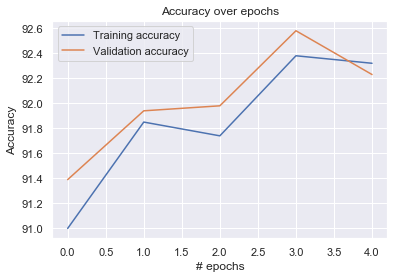

In [18]:
dim_input = 28*28
dim_output = 10

network = LinearNetwork(dim_input, dim_output)
optimizer = SGD(network.parameters(), 0.01)

train_acc, val_acc = training_loop(network, 
                                   optimizer, 
                                   train_data, 
                                   dev_data, 
                                   n_epochs=5)

acc = accuracy(network, test_data)*100
print('       accuracy on validation set: {}'.format(acc))

visualize(train_acc, val_acc)

After you finished the linear network, you can move to a deep network!
The tanh argument can be used to switch between relu or tanh. Warning: use the correct initialization for a given activation!

In [19]:
class DeepNetwork(Module):
    def __init__(self, dim_input, dim_output, hidden_dim, n_layers, tanh=False):
        self.W = ModuleList()
        self.b = ModuleList()

        self.W.append(Parameter(np.zeros((hidden_dim, dim_input))))
        self.b.append(Parameter(np.zeros((hidden_dim,))))
        
        for i in range(n_layers - 1):
          self.W.append(Parameter(np.zeros((hidden_dim, hidden_dim))))
          self.b.append(Parameter(np.zeros((hidden_dim,))))
        
        # TODO...
        
        self.output_proj = Parameter(np.zeros((dim_output, hidden_dim)))
        self.output_bias = Parameter(np.zeros((dim_output,)))
        
        self.init_parameters()
        
    def init_parameters(self):
        for paramW, paramb in zip(self.W, self.b):
          glorot_init(paramW.data)
          zero_init(paramb.data)

    def forward(self, x):
        for paramW, paramb in zip(self.W, self.b):
            x = affine_transform(paramW, paramb, x)
            if tanh:
                x = tanh(x)
            else:
                x = relu(x)
        return affine_transform(self.output_proj, self.output_bias, x)

Starting epoch 1
       accuracy on validation set: 10.299999999999999
       accuracy on validation set: 86.75
       accuracy on validation set: 88.58
       accuracy on validation set: 89.52
       accuracy on validation set: 90.64
       accuracy on validation set: 90.12
       accuracy on validation set: 90.88000000000001
       accuracy on validation set: 90.19
       accuracy on validation set: 90.94
       accuracy on validation set: 90.27
       accuracy on validation set: 90.91
       accuracy on validation set: 92.25999999999999
       accuracy on validation set: 91.67
       accuracy on validation set: 91.8
       accuracy on validation set: 91.97999999999999
       accuracy on validation set: 92.06
       accuracy on validation set: 91.88
       accuracy on validation set: 92.42
       accuracy on validation set: 91.88
       accuracy on validation set: 92.44
Starting epoch 2
       accuracy on validation set: 93.0
       accuracy on validation set: 93.19
       accuracy o

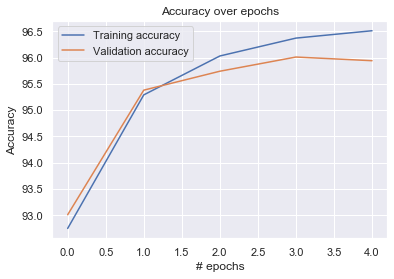

In [20]:
dim_input = 28*28
dim_output = 10

network = DeepNetwork(dim_input, dim_output, 100, 1, tanh=False)
optimizer = SGD(network.parameters(), 0.01)

train_acc, val_acc = training_loop(network, 
                                   optimizer, 
                                   train_data, 
                                   dev_data, 
                                   n_epochs=5)

acc = accuracy(network, test_data)*100
print('       accuracy on validation set: {}'.format(acc))

visualize(train_acc, val_acc)

Starting epoch 1
       accuracy on validation set: 10.09
       accuracy on validation set: 86.45
       accuracy on validation set: 88.35
       accuracy on validation set: 89.17
       accuracy on validation set: 90.05
       accuracy on validation set: 90.11
       accuracy on validation set: 91.59
       accuracy on validation set: 90.10000000000001
       accuracy on validation set: 91.43
       accuracy on validation set: 91.89
       accuracy on validation set: 91.14999999999999
       accuracy on validation set: 91.53999999999999
       accuracy on validation set: 92.33
       accuracy on validation set: 92.84
       accuracy on validation set: 91.44
       accuracy on validation set: 92.2
       accuracy on validation set: 91.12
       accuracy on validation set: 91.95
       accuracy on validation set: 92.19000000000001
       accuracy on validation set: 93.01
Starting epoch 2
       accuracy on validation set: 93.45
       accuracy on validation set: 92.53
       accuracy o

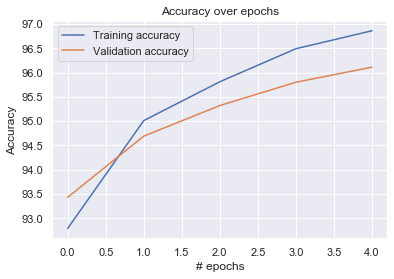

In [21]:
dim_input = 28*28
dim_output = 10

network = DeepNetwork(dim_input, dim_output, 100, 1, tanh=True)
optimizer = SGD(network.parameters(), 0.01)

train_acc, val_acc = training_loop(network, 
                                   optimizer, 
                                   train_data, 
                                   dev_data, 
                                   n_epochs=5)

acc = accuracy(network, test_data)*100
print('       accuracy on validation set: {}'.format(acc))

visualize(train_acc, val_acc)